# MNIST 100 - Training

##Imports

In [85]:
import torch
import torchvision
from torch import optim 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from numpy.random import randint
from typing import Dict, List
import cv2
import glob
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [71]:
!pip install torchmetrics
import torchmetrics

In [72]:
def dataset_to_dict(data_images,data_labels) -> Dict[int,List[np.ndarray]]:
    '''
    Turns dataset into dictionary

    # Returns
        Dictionary where the labels are the keys and data stored on each entry as a list og numpy.ndarray
    '''
    numbers = {}
    for img, label in zip(data_images, data_labels):
        if label not in numbers.keys():
            numbers[label] = []
        numbers[label] += [img]

    return numbers

def build_dataset(numbers:dict, to_tensor=True, amount:int=500):
    '''
    turns Mnist dataset into new dataset of numbers [0-100]
    '''
    data = None
    targets = np.array([])
    print('Building: 0',end='')
    for hundreds,tens,unit in np.ndindex(2,10,10):
        target = 100*hundreds + 10*tens + unit
        if(target > 100):      
            break
        nset = np.array([])
        while len(nset) < amount:
            r_unit, r_tens, r_hundreds = randint(0, len(numbers[unit])), randint(0,len(numbers[tens])), randint(0,len(numbers[hundreds]))
            permutation = np.concatenate([numbers[hundreds][r_hundreds],numbers[tens][r_tens],numbers[unit][r_unit]], axis=1)
            if nset.size == 0:    
                nset = permutation.reshape([1,28,84])
            else:
                nset = np.append(nset, [permutation], axis=0)
                
            if len(nset) % amount == 0:
                nset = np.unique(nset,axis=0) # to ensure there are no redundent permutation of an image    
        if data is None:
            data = nset
        else:
            data = np.append(data, nset, axis=0)
        targets = np.append(targets, np.ones(amount)*target, axis=0).astype(int)
        print('.', end='')
    print("100\nDone!")
    
    if to_tensor:
        return  torch.from_numpy(data), torch.from_numpy(targets)
    return data,targets

FocalLoss class

In [87]:
class FocalLoss(nn.Module): #implement youreself
    def __init__(self, alpha=0.2, gamma=2, logist=False, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # the scalar factor between 0 and 1 
        self.gamma = gamma # focusing parameter(always positive) that reduces the relative loss for well-classified examples and puts more focus on hard misclassified examples
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        #self.logist = logist # log probabilities 
        self.reduce = reduce # Specifies the reduction to apply to the output - none/mean/sum. ‘none’: no reduction will be applied, ‘mean’: the sum of the output will be divided by the number of elements in the output, ‘sum’: the output will be summed.

    def forward(self, inputs, targets):
        BCE_loss = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [74]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [75]:
def train(dataloader, model, criterion, optimizer, epoch):
  acc = AverageMeter()
  losses = AverageMeter()
  
  model.train()
  loss_accumlated = 0
  acc_accumlated = 0
  for x_batch, y_batch in tqdm(dataloader, desc=f'[Epoch {epoch+1}/{epoch}]'):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()
    output = model(x_batch.float()) #output [BatchXNumClass]
    loss = criterion(output, y_batch.long())

    loss.backward()
    losses.update(loss.item(), x_batch.size(0))
    loss_accumlated += loss.item()
    optimizer.step()
    
    accuracy = torchmetrics.functional.accuracy(output.argmax(dim=-1), y_batch.long())
    acc.update(accuracy.item(), x_batch.size(0))
    acc_accumlated += accuracy.item()

  print(f'\tTrain      - Average Accuracy per batch = {(100 * acc.avg):.6f} , Average Loss per batch {losses.avg:.6f}')
  return loss_accumlated, 100 * acc.avg

In [105]:
def validation(dataloader, model, criterion, optimizer, epoch,printValues = True):
  valid_acc = AverageMeter()
  valid_losses  = AverageMeter()
  loss_accumlated = 0
  acc_accumlated = 0
  model.eval()
  for x_batch, y_batch in tqdm(dataloader, desc=f'[Epoch {epoch+1}/{epoch}]'):
     # Transfer Data to GPU if available
  
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    output = model(x_batch.float()) #output [BatchXNumClass]
    loss = criterion(output, y_batch.long())

    valid_losses.update(loss.item(), x_batch.size(0))
    loss_accumlated += loss.item()

    
    accuracy = torchmetrics.functional.accuracy(output.argmax(dim=-1), y_batch.long())
    valid_acc.update(accuracy.item(), x_batch.size(0))
    acc_accumlated += accuracy.item()
    
  if printValues:  
    print(f'\tValidation - Average Accuracy per batch = {(100 * valid_acc.avg):.6f} , Average Loss per batch {valid_losses.avg:.6f}')
  return loss_accumlated , 100 * valid_acc.avg

# Mnist dataset class

In [78]:
class MnistDataSet(Dataset):
  def __init__(self, data, labels, transforms=None):
    self.x = data
    self.y = labels
    self.transforms = transforms

  def __getitem__(self, idx):
    x = self.x[idx]
    y = self.y[idx]
    if self.transforms:
      x = self.transforms(image = x.numpy())
      x = x['image']
    return x[np.newaxis, :, :], y

  def __len__(self):
    return len(self.x)

## Download Data And create a 101 classes mnist data set

In [80]:
train_set = torchvision.datasets.MNIST(root='',download=True)
data_images = train_set.data.numpy()
data_labels = train_set.targets.numpy()
numbers = dataset_to_dict(data_images,data_labels)
X, y = build_dataset(numbers, amount=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
len(X_train),len(X_test),len(X_val)




Building: 0.....................................................................................................100
Done!


(72720, 20200, 8080)

# Train loader

In [81]:

classes = [x for x in range(101)] 
batch_size = 50

mnist100_trainset = MnistDataSet(X_train, y_train)
mnist100_valset = MnistDataSet(X_val, y_val)

train_mnist100_loader = DataLoader(mnist100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_mnist100_loader = DataLoader(mnist100_valset, batch_size=batch_size, shuffle=True, num_workers=2)



print(f"number of classes:{num_classes}")

number of classes:101


# Lenet CNN

In [82]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=1152, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=101)
        
        

    def forward(self, x):
        x = self.conv1(x.float())
        x= F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model ,loss function and optimizer

In [88]:
model = LeNet()
model.to(device)
criterion = FocalLoss()
criterion.to(device)

opt = optim.Adam(model.parameters(), lr = 0.001)
opt2 = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)


# train and validate the model

In [89]:

EPOCHS = 20

train_losses = []
val_losses = []

train_accuracies  = []
val_accuracies = []

for e in range(EPOCHS):
  train_loss, train_acc = train(dataloader=train_mnist100_loader, model=model, criterion=criterion, optimizer=opt, epoch=e)
  valid_loss, val_acc = validation(dataloader=val_mnist100_loader, model=model, criterion=criterion, optimizer=opt,epoch=e)
  train_losses.append(train_loss)
  val_losses.append(valid_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)


	Train      - Average Accuracy per batch = 78.843509 , Average Loss per batch 0.091651



	Validation - Average Accuracy per batch = 91.101485 , Average Loss per batch 0.005087



	Train      - Average Accuracy per batch = 93.121562 , Average Loss per batch 0.002835



	Validation - Average Accuracy per batch = 93.019802 , Average Loss per batch 0.002834



	Train      - Average Accuracy per batch = 94.130913 , Average Loss per batch 0.001772



	Validation - Average Accuracy per batch = 93.799505 , Average Loss per batch 0.002465



	Train      - Average Accuracy per batch = 94.415566 , Average Loss per batch 0.002254



	Validation - Average Accuracy per batch = 95.903465 , Average Loss per batch 0.001047



	Train      - Average Accuracy per batch = 95.398790 , Average Loss per batch 0.001449



	Validation - Average Accuracy per batch = 95.123762 , Average Loss per batch 0.001642



	Train      - Average Accuracy per batch = 96.490649 , Average Loss per batch 0.000603



	Validation - Average Accuracy per batch = 87.747524 , Average Loss per batch 0.012522



	Train      - Average Accuracy per batch = 95.666942 , Average Loss per batch 0.001044



	Validation - Average Accuracy per batch = 94.146040 , Average Loss per batch 0.001900



	Train      - Average Accuracy per batch = 96.281628 , Average Loss per batch 0.001591



	Validation - Average Accuracy per batch = 92.636138 , Average Loss per batch 0.003261



	Train      - Average Accuracy per batch = 96.545655 , Average Loss per batch 0.000535



	Validation - Average Accuracy per batch = 95.977723 , Average Loss per batch 0.000898



	Train      - Average Accuracy per batch = 98.085809 , Average Loss per batch 0.000108



	Validation - Average Accuracy per batch = 95.581683 , Average Loss per batch 0.001360



	Train      - Average Accuracy per batch = 95.567932 , Average Loss per batch 0.001908



	Validation - Average Accuracy per batch = 95.829208 , Average Loss per batch 0.000985



	Train      - Average Accuracy per batch = 97.909791 , Average Loss per batch 0.000136



	Validation - Average Accuracy per batch = 96.076733 , Average Loss per batch 0.001114



	Train      - Average Accuracy per batch = 96.976073 , Average Loss per batch 0.000877



	Validation - Average Accuracy per batch = 95.222772 , Average Loss per batch 0.001418



	Train      - Average Accuracy per batch = 97.303355 , Average Loss per batch 0.000290



	Validation - Average Accuracy per batch = 95.816832 , Average Loss per batch 0.001134



	Train      - Average Accuracy per batch = 96.515402 , Average Loss per batch 0.000723



	Validation - Average Accuracy per batch = 94.071782 , Average Loss per batch 0.003920



	Train      - Average Accuracy per batch = 97.626513 , Average Loss per batch 0.000212



	Validation - Average Accuracy per batch = 96.732673 , Average Loss per batch 0.000947



	Train      - Average Accuracy per batch = 97.189219 , Average Loss per batch 0.000891



	Validation - Average Accuracy per batch = 95.903465 , Average Loss per batch 0.001076



	Train      - Average Accuracy per batch = 97.637514 , Average Loss per batch 0.000212



	Validation - Average Accuracy per batch = 96.027228 , Average Loss per batch 0.001316



	Train      - Average Accuracy per batch = 98.470847 , Average Loss per batch 0.000068



	Validation - Average Accuracy per batch = 95.928218 , Average Loss per batch 0.001132



	Train      - Average Accuracy per batch = 97.013202 , Average Loss per batch 0.001180



	Validation - Average Accuracy per batch = 95.841584 , Average Loss per batch 0.001260


# accuracies and losses on the train and validation 

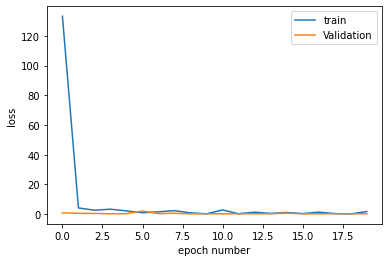

In [90]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.ylabel('loss')
plt.xlabel('epoch number')
plt.legend(["train", "Validation"])
plt.show()


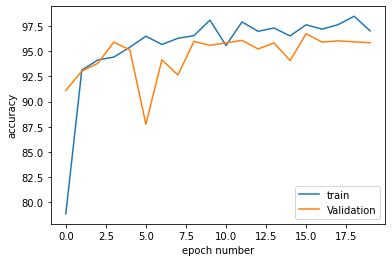

In [91]:

plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.ylabel('accuracy')
plt.xlabel('epoch number')
plt.legend(["train", "Validation"])
plt.show()

# Bonus part - confusion matrix and evaluate the trained model on the test data

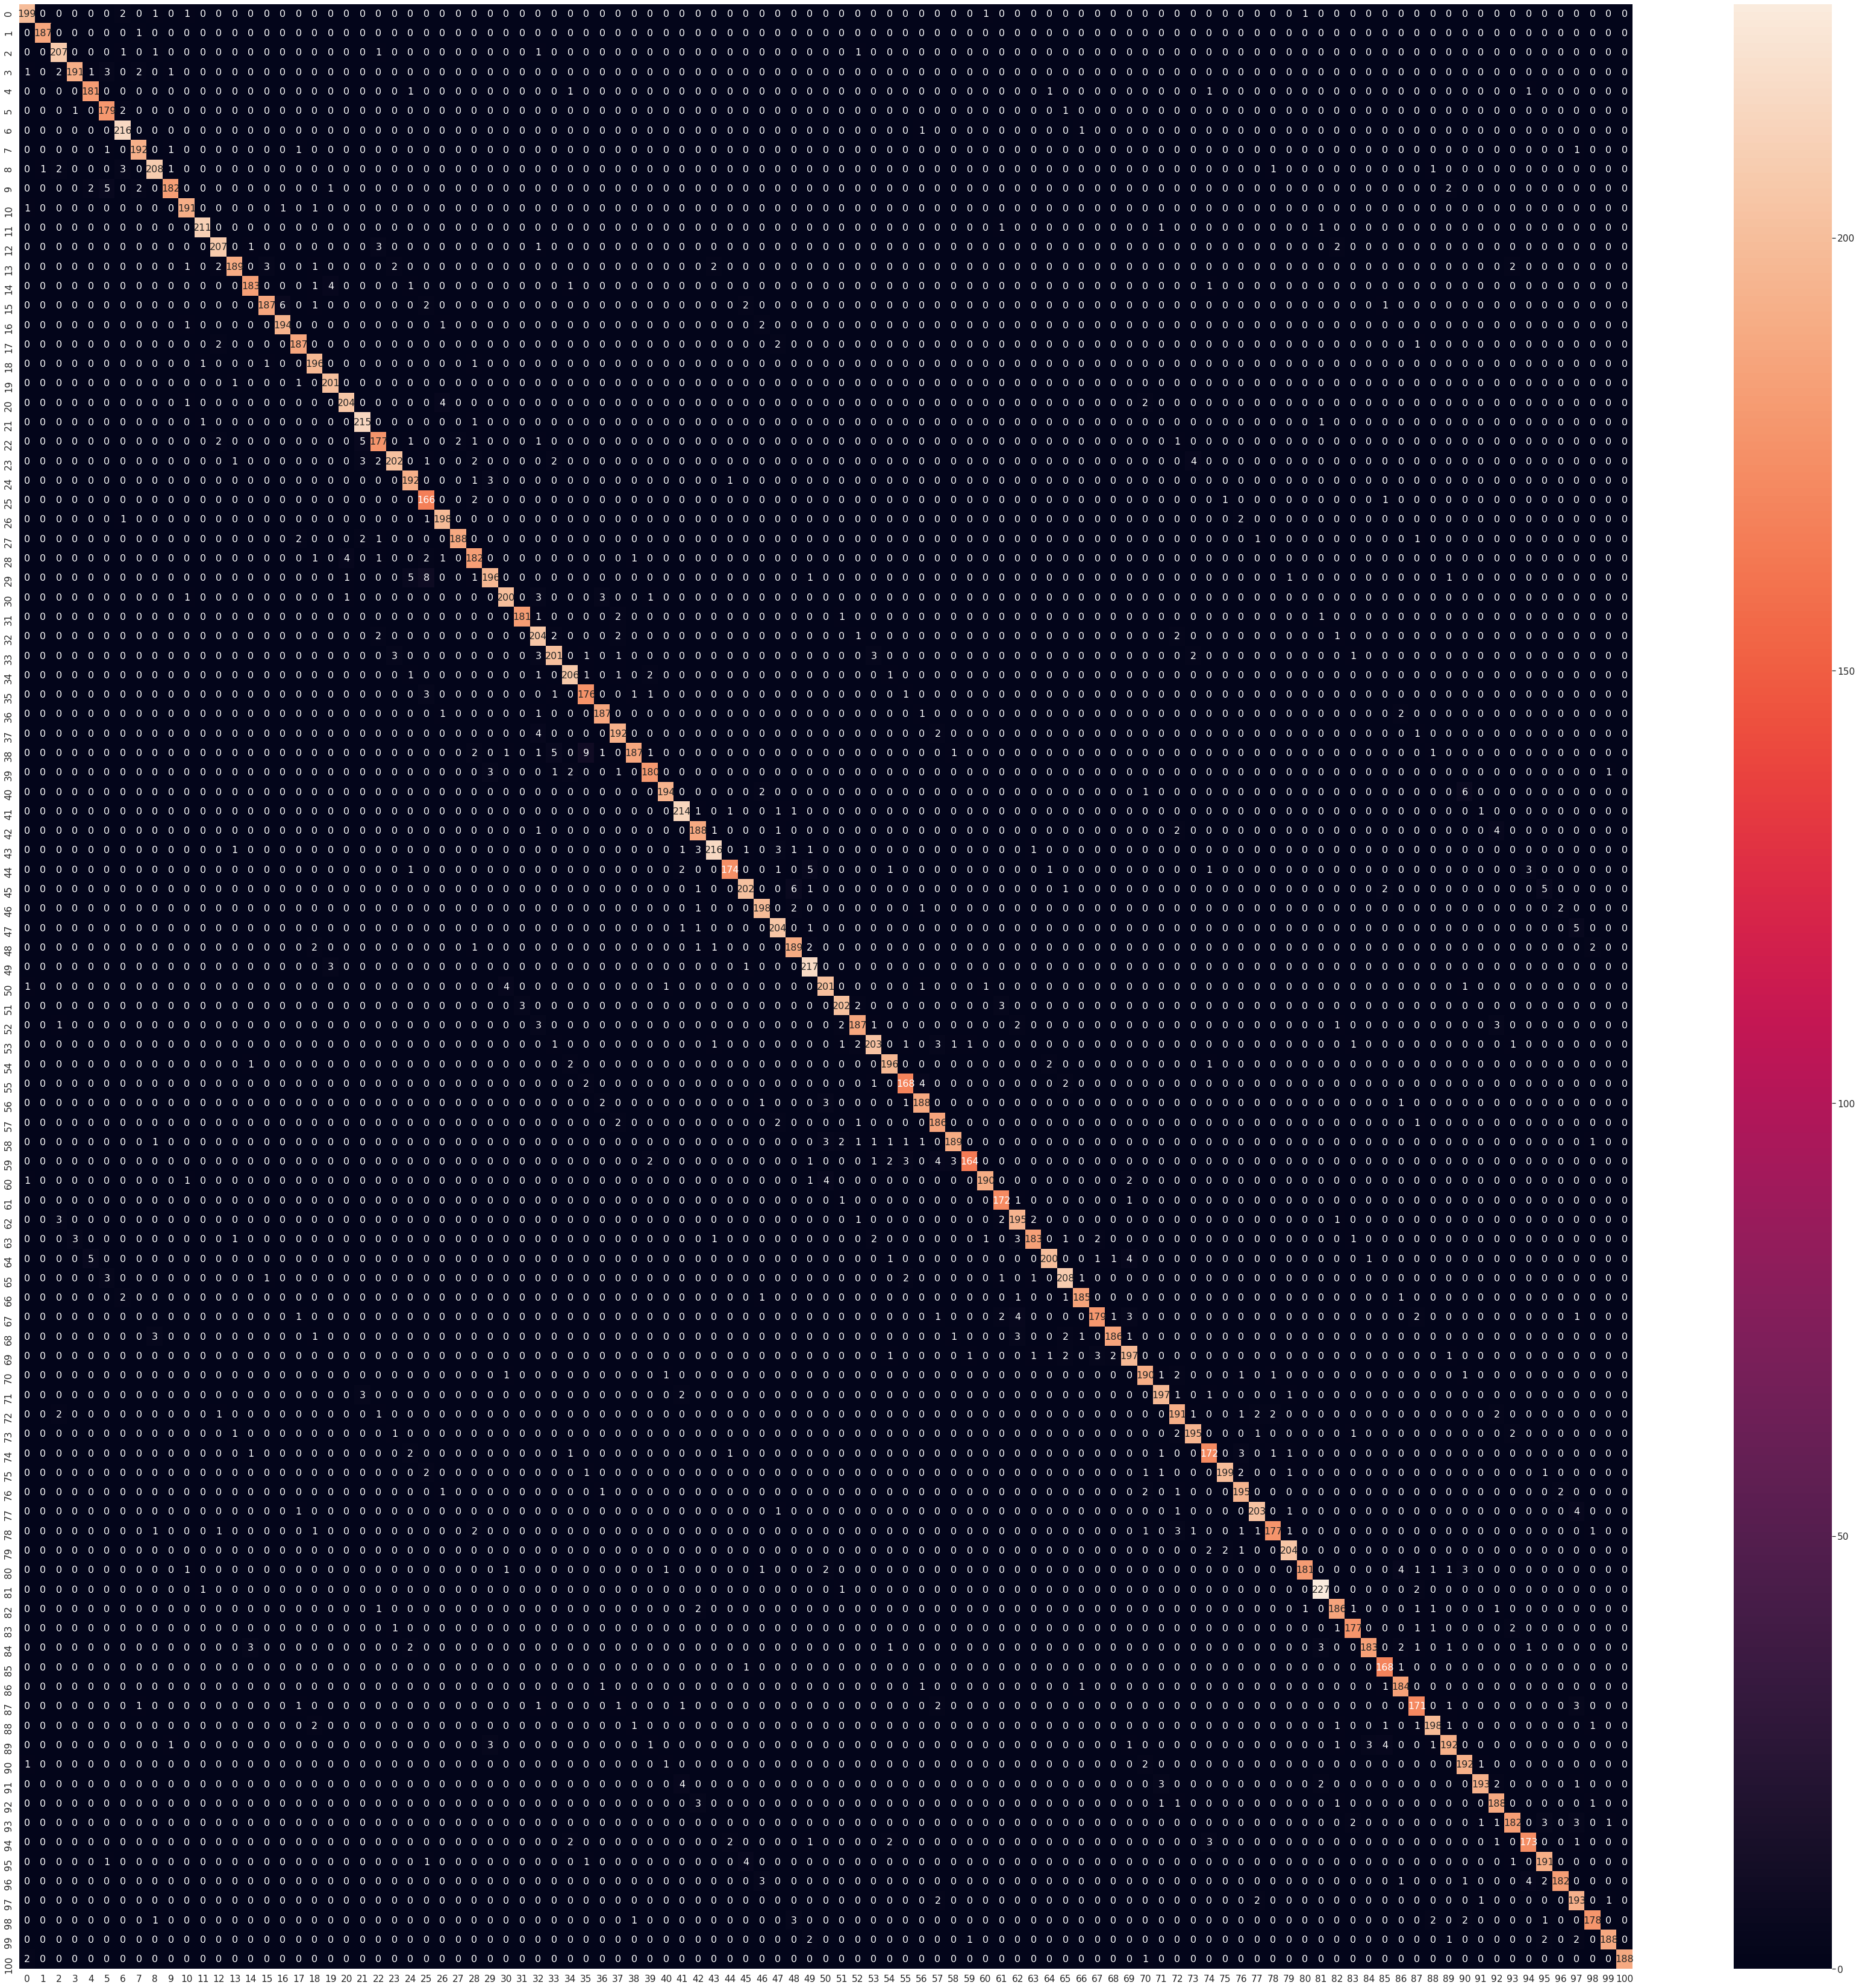

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


cm = confusion_matrix(y_test, y_pred).astype('uint8')

df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (60,60))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g');

In [102]:
mnist100_test = MnistDataSet(X_test, y_test)
test_mnist100_loader = DataLoader(mnist100_test, batch_size=1, shuffle=True, num_workers=2)


In [106]:
_, test_acc = validation(dataloader=test_mnist100_loader, model=model, criterion=criterion, optimizer=opt,epoch=1, printValues=False)


In [110]:
print(f'accuracy on the test : {test_acc} %')


accuracy on the test : 95.71782178217822 %


# summary
* The way wasn't free of errors mainly the training part on the extended dataset.
* After much trial and error I was able to achieve a relatively high results on the validation/test than the 70% accuracy that was requested.

* In this project we experimented and researched error function, optimizers and how to train and evaluate a data set that we prepared ourselves.